# SandBox - Assignment2

This script is made only to see the effects of each processing step (centering,rereferencing,filtering) both on time and frequency domains

## Import libraries

In [149]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
#%matplotlib widget


In [150]:
plt.close("all")  # close all figure windows

## Initialization

### Generate a signal

In [151]:
Srate=60
length_time=20
change_time=length_time/2
signal_frequency1=12
signal_frequency2=20
original_amp=1
new_amp=original_amp*0.8


times,signal_amplitudes1=generate_sine_wave(amplitude=original_amp, frequency=signal_frequency1, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp, sample_rate=Srate)
times2,signal_amplitudes2=generate_sine_wave(amplitude=20, frequency=signal_frequency2, duration=length_time, 
                               change_time=change_time, new_amplitude=10, sample_rate=Srate)

In [152]:
signal_electrodes=np.column_stack((signal_amplitudes1,signal_amplitudes2)) #stacking the signals electrodes 
print(signal_electrodes.shape)

(1200, 2)


### Electrode selector

In [153]:
ELECTRODE_NUM=1
SELECTOR=ELECTRODE_NUM-1 #Due to python indices

### Define markers

In [154]:
marker_timestamps=np.array([(change_time-3,100),(change_time,111),(change_time+3,100),(change_time+6,111)])


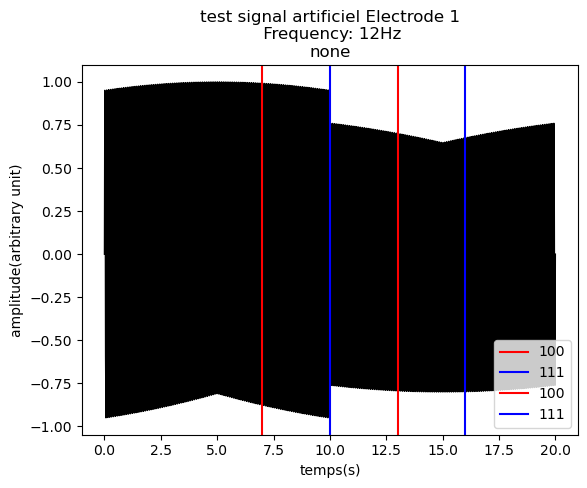

In [155]:
single_plot(filename="none",fig_number=1,x=times,y=signal_electrodes[:,SELECTOR],markers_times_array=marker_timestamps,
            fig_title="test signal artificiel Electrode "+str(ELECTRODE_NUM)+"\n Frequency: "+ str(eval("signal_frequency"+str(ELECTRODE_NUM)))+"Hz",
            xlabel="temps(s)",ylabel="amplitude(arbitrary unit)")

### Compute the signals PSD

In [156]:
nearest_marker_indices_timestamps = nearest_timestamps_array_finder(
    times, marker_timestamps)

MARKERS LEN: 4


In [157]:
time_window=1 # Segment length of the signal on which the PSD is computed (expressed in seconds)
tridi_freqs_before, tridi_Pxx_densities_before = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                    time_lag=time_window, direction="before")

lower_end: 360
Higher_end: 480
segment coordinates before marker: ( 360 ; 420 ), delta_index: 60
segment coordinates after marker: ( 420 ; 480 ), delta_index: 60
lower_end: 539
Higher_end: 659
segment coordinates before marker: ( 539 ; 599 ), delta_index: 60
segment coordinates after marker: ( 599 ; 659 ), delta_index: 60
lower_end: 719
Higher_end: 839
segment coordinates before marker: ( 719 ; 779 ), delta_index: 60
segment coordinates after marker: ( 779 ; 839 ), delta_index: 60
lower_end: 899
Higher_end: 1019
segment coordinates before marker: ( 899 ; 959 ), delta_index: 60
segment coordinates after marker: ( 959 ; 1019 ), delta_index: 60
lower_end: 360
Higher_end: 480
segment coordinates before marker: ( 360 ; 420 ), delta_index: 60
segment coordinates after marker: ( 420 ; 480 ), delta_index: 60
lower_end: 539
Higher_end: 659
segment coordinates before marker: ( 539 ; 599 ), delta_index: 60
segment coordinates after marker: ( 599 ; 659 ), delta_index: 60
lower_end: 719
Higher_end:

In [158]:
tridi_freqs_after, tridi_Pxx_densities_after = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                  time_lag=time_window, direction="after")

lower_end: 360
Higher_end: 480
segment coordinates before marker: ( 360 ; 420 ), delta_index: 60
segment coordinates after marker: ( 420 ; 480 ), delta_index: 60
lower_end: 539
Higher_end: 659
segment coordinates before marker: ( 539 ; 599 ), delta_index: 60
segment coordinates after marker: ( 599 ; 659 ), delta_index: 60
lower_end: 719
Higher_end: 839
segment coordinates before marker: ( 719 ; 779 ), delta_index: 60
segment coordinates after marker: ( 779 ; 839 ), delta_index: 60
lower_end: 899
Higher_end: 1019
segment coordinates before marker: ( 899 ; 959 ), delta_index: 60
segment coordinates after marker: ( 959 ; 1019 ), delta_index: 60
lower_end: 360
Higher_end: 480
segment coordinates before marker: ( 360 ; 420 ), delta_index: 60
segment coordinates after marker: ( 420 ; 480 ), delta_index: 60
lower_end: 539
Higher_end: 659
segment coordinates before marker: ( 539 ; 599 ), delta_index: 60
segment coordinates after marker: ( 599 ; 659 ), delta_index: 60
lower_end: 719
Higher_end:

In [159]:
# separation of the markers of each 3d array (before and after)
tridi_Pxx_densities_111_before = tridi_Pxx_densities_before[:, 1::2, :]
tridi_Pxx_densities_111_after = tridi_Pxx_densities_after[:, 1::2, :]

tridi_Pxx_densities_100_before = tridi_Pxx_densities_before[:, 0::2, :]
tridi_Pxx_densities_100_after = tridi_Pxx_densities_after[:, 0::2, :]

In [160]:
# compute the ratio of the Pxx_densities of each side of each marker(12*2) of each of the 8 channel
# need (PSDafter-PSDbefore/PSDbefore)*100
tridi_Pxx_densities_ratio_111 = ((
    tridi_Pxx_densities_111_after-tridi_Pxx_densities_111_before)/tridi_Pxx_densities_111_before)*100
tridi_Pxx_densities_ratio_100 = ((
    tridi_Pxx_densities_100_before-tridi_Pxx_densities_111_after)/tridi_Pxx_densities_111_after)*100

if np.array_equal(tridi_freqs_after,tridi_freqs_before) :
    tridi_freqs_ratio=tridi_freqs_after

### Plot the PSDs

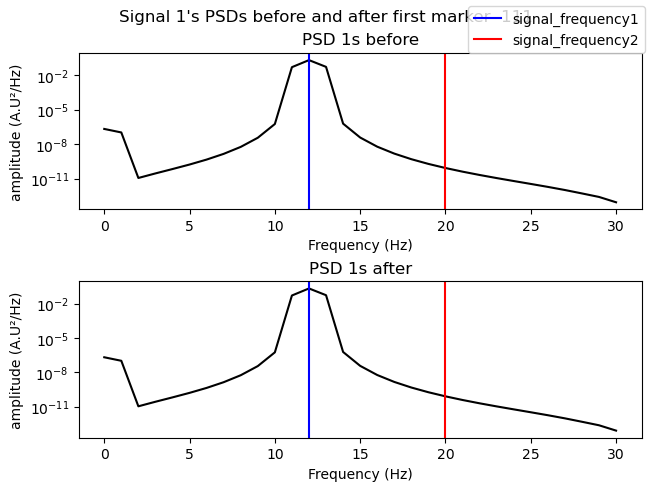

In [161]:
figure,axis=plt.subplots(2,num=2,layout="constrained")
figure.suptitle("Signal "+str(ELECTRODE_NUM)+"'s PSDs before and after first marker  111")
axis[0].set_title("PSD "+str(time_window) +"s before")
axis[0].set_ylabel("amplitude (A.U²/Hz)")
axis[0].set_xlabel("Frequency (Hz)")
axis[0].semilogy(tridi_freqs_ratio[:, 0, SELECTOR],tridi_Pxx_densities_111_before[:, 1, SELECTOR],color="black")
axis[0].axvline(x=signal_frequency1,color="b",label="signal_frequency1")
axis[0].axvline(x=signal_frequency2,color="r",label="signal_frequency2")

axis[1].set_title("PSD "+str(time_window) +"s after")
axis[1].set_ylabel("amplitude (A.U²/Hz)")
axis[1].set_xlabel("Frequency (Hz)")
axis[1].semilogy(tridi_freqs_ratio[:, 0, SELECTOR],tridi_Pxx_densities_111_before[:, 1, SELECTOR],color="black")
axis[1].axvline(x=signal_frequency1,color="b",label="_signal_frequency1")
axis[1].axvline(x=signal_frequency2,color="r",label="_signal_frequency2")

figure.legend()


### Plot the electrode i's first marker ERSP over specific time window 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


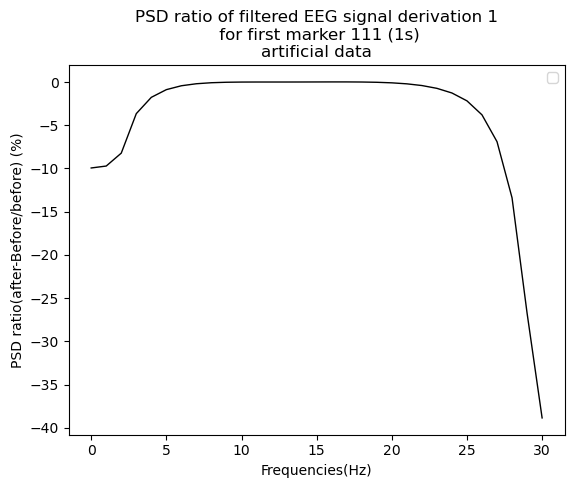

In [162]:
single_plot("artificial data", fig_number=3, x=tridi_freqs_ratio[:, 0, SELECTOR], y=tridi_Pxx_densities_ratio_111[:, 1, SELECTOR],
            fig_title="PSD ratio of filtered EEG signal derivation " +
            str(1)+
            "\n for first marker 111 ("+str(time_window)+"s)",
            xlabel="Frequencies(Hz)", ylabel="PSD ratio(after-Before/before) (%)")

Conclusion: Probleme données ratio reproduit. Persistant sur signal artificiel. Les PSD sont coherentes avec les caracteristiques des signaux generés.

Causes possibles: 
1. Elementwise operation: ecartée car fonctionne en soustraction (et syntaxe correcte)
2. Separation des matrices marqueurs 111 et 100, avant et apres: mauvaise selection?
3. Bug de la fonction nearest_timestamps_array_finder() qui associe a chaque temps de marqueur le temps le plus proche correspondant a un echantillion dans le signal.